In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import os
import glob
import cv2

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorboard
import datetime

pathOfImages = 'C:/Users/hp/Jupyter Notebook Work/Practicum - Face Mask Detection/Dataset/images'
pathOfAnnotations = 'C:/Users/hp/Jupyter Notebook Work/Practicum - Face Mask Detection/Dataset/annotations'

In [13]:
image_path= pathlib.Path(pathOfImages)
annot_path = pathlib.Path(pathOfAnnotations)

In [14]:
# Preprocessing the images - resize the face as required

def preprocess_images(dataframe):
    classes = ["without_mask","mask_weared_incorrect","with_mask"]
    labels = []
    data = []
    
    print("Processing Starts...")
    
    image_directories = sorted(glob.glob(os.path.join(image_path,"*.png")))
    
    for idx, image in enumerate(image_directories): # Extract data into respective label folders
        img  = cv2.imread(image)
        
        X, Y = dataframe["Dimensions"][idx]
        cv2.resize(img,(int(X),int(Y))) # scale to dimension
        
        for obj in dataframe.columns[3:]: # find the face in each object
            info = dataframe[obj][idx]
            
            if info!=0:
                label = info[0] 
                info[0] = info[0].replace(str(label), str(classes.index(label))) # replace label with the index from classes list
                info=[int(each) for each in info]
                face = img[info[2]:info[4],info[1]:info[3]]
                
                if((info[3]-info[1] > 13) and (info[4]-info[2]) > 13): # Set a minimum size of 13 x 13 for face detection to improve model performance
                    try:
                        face = cv2.resize(face, (224, 224)) # resize the faces to 224 x 224
                        face = img_to_array(face)
                        face = preprocess_input(face)
                        data.append(face)
                        labels.append(label)

                    except:
                        pass
                    
    data = np.array(data, dtype="float32")
    labels = np.array(labels)
    
    print("Processing Complete.")
    return data, labels
    

In [15]:
# Check label counts after limiting data to bounding boxes with > 13x13 dims

def check_lables_after_resizing(data, labels):
       
    label_dict = {'with_mask': 0, 'without_mask': 0, 'mask_weared_incorrect': 0}

    for i in labels:
        label_dict[i] += 1

    print('')
    print("After Resixing: ")
    print("Total faces for model: ", len(labels))
    print("Faces with mask: ", label_dict['with_mask'])
    print("Faces without mask: ", label_dict['without_mask'])
    print("Faces with mask worn incorrectly: ", label_dict['mask_weared_incorrect'])

In [16]:
def MobileNetV2_modelling(data, labels, X_train, X_test, y_train, y_test):
    print('')
    print('Started Modelling')
    print('')
    
    aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")
    
    baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))) # load base model with imagenet pre-trained weights
    
    headModel = baseModel.output # build top layer
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(3, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel) # combine base model and head model layers, this will be the model used for training

    for layer in baseModel.layers: # freeze base model layers so that they will not be updated during the training process. This way, only the head layers are adjusted during back propogation.
        layer.trainable = False
        
    %reload_ext tensorboard
    logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    callback1 = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # add callbacks - one for early stopping, and one that will create a tensorboard for evaluation
    callback2 = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)
    
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]) # Compile Model
        
    history = model.fit(aug.flow(X_train, y_train, batch_size=BS), steps_per_epoch=len(X_train) // BS, validation_data=(X_test, y_test), validation_steps=len(X_test) // BS, epochs=EPOCHS, callbacks=[callback1, callback2])
    
    print('')
    print('Modelling Completed.')
    
    print('')
    print('Summary of the Model:')
    model.summary()
    
    return model, history

In [17]:
def model_evaluation(history):
    N = len(history.epoch)
    plt.style.use("ggplot")
    plt.figure(figsize = (8, 4))
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
    plt.title("Loss and Accuracy by Epoch")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="best");

In [18]:
def model_prediction(model, X_train, X_test, y_train, y_test, BS, lb):
    predIdxs = model.predict(X_test, batch_size=BS) # make predictions on the testing set
    
    predIdxs = np.argmax(predIdxs, axis=1) # find the index of the label with corresponding largest predicted probability
    
    print('')
    print('')
    print('')
    
    print(classification_report(y_test.argmax(axis=1), predIdxs, target_names=lb.classes_))
    
    cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)
    
    plt.style.use("ggplot")
    plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks(np.arange(len(cm)), ['Worn Incorrectly', 'With Mask', 'Without Mask'], rotation=45, size='large')
    plt.yticks(np.arange(len(cm)), ['Worn Incorrectly', 'With Mask', 'Without Mask'], rotation=45, size='large')
    plt.title('Confusion matrix ')
    plt.grid(None)
    plt.colorbar()
    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.text(j, i, cm[i, j], ha='center', va='center', size='large')
    plt.show()
    
    print('')
    print('More Precisely: ')
    %tensorboard --logdir logs/fit
    
    # Reference - https://stackoverflow.com/questions/51282098/plotting-confusion-matrix-for-an-image-classification-model

Processing Starts...
Processing Complete.

After Resixing: 
Total faces for model:  3707
Faces with mask:  2971
Faces without mask:  616
Faces with mask worn incorrectly:  120

Started Modelling



C:\Users\hp\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/25
39/39 [==============================] - 125s 3s/step - loss: 0.7085 - accuracy: 0.7643 - val_loss: 0.4518 - val_accuracy: 0.8284
Epoch 2/25
39/39 [==============================] - 108s 3s/step - loss: 0.4642 - accuracy: 0.8343 - val_loss: 0.3793 - val_accuracy: 0.8688
Epoch 3/25
39/39 [==============================] - 121s 3s/step - loss: 0.4251 - accuracy: 0.8486 - val_loss: 0.3464 - val_accuracy: 0.8778
Epoch 4/25
39/39 [==============================] - 123s 3s/step - loss: 0.3648 - accuracy: 0.8750 - val_loss: 0.3287 - val_accuracy: 0.8832
Epoch 5/25
39/39 [==============================] - 122s 3s/step - loss: 0.3528 - accuracy: 0.8762 - val_loss: 0.3136 - val_accuracy: 0.8904
Epoch 6/25
39/39 [==============================] - 127s 3s/step - loss: 0.3421 - accuracy: 0.8790 - val_loss: 0.3119 - val_accuracy: 0.8958
Epoch 7/25
39/39 [==============================] - 135s 3s/step - loss: 0.3531 - accuracy: 0.8710 - val_loss: 0.3288 - val_accuracy: 0.8868
Epoch 8/25
39

 block_1_project (Conv2D)       (None, 56, 56, 24)   2304        ['block_1_depthwise_relu[0][0]'] 
                                                                                                  
 block_1_project_BN (BatchNorma  (None, 56, 56, 24)  96          ['block_1_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_2_expand (Conv2D)        (None, 56, 56, 144)  3456        ['block_1_project_BN[0][0]']     
                                                                                                  
 block_2_expand_BN (BatchNormal  (None, 56, 56, 144)  576        ['block_2_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_2_e

 block_5_depthwise_BN (BatchNor  (None, 28, 28, 192)  768        ['block_5_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_5_depthwise_relu (ReLU)  (None, 28, 28, 192)  0           ['block_5_depthwise_BN[0][0]']   
                                                                                                  
 block_5_project (Conv2D)       (None, 28, 28, 32)   6144        ['block_5_depthwise_relu[0][0]'] 
                                                                                                  
 block_5_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_5_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_5_a

 block_9_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_9_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_9_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_9_expand_BN[0][0]']      
                                                                                                  
 block_9_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_9_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_9_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_9_depthwise[0][0]']      
 malization)                                                                                      
          

                                                                                                  
 block_12_add (Add)             (None, 14, 14, 96)   0           ['block_11_add[0][0]',           
                                                                  'block_12_project_BN[0][0]']    
                                                                                                  
 block_13_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_12_add[0][0]']           
                                                                                                  
 block_13_expand_BN (BatchNorma  (None, 14, 14, 576)  2304       ['block_13_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_13_expand_relu (ReLU)    (None, 14, 14, 576)  0           ['block_13_expand_BN[0][0]']     
          

 rmalization)                                                                                     
                                                                                                  
 block_16_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_16_depthwise_BN[0][0]']  
                                                                                                  
 block_16_project (Conv2D)      (None, 7, 7, 320)    307200      ['block_16_depthwise_relu[0][0]']
                                                                                                  
 block_16_project_BN (BatchNorm  (None, 7, 7, 320)   1280        ['block_16_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 Conv_1 (Conv2D)                (None, 7, 7, 1280)   409600      ['block_16_project_BN[0][0]']    
          

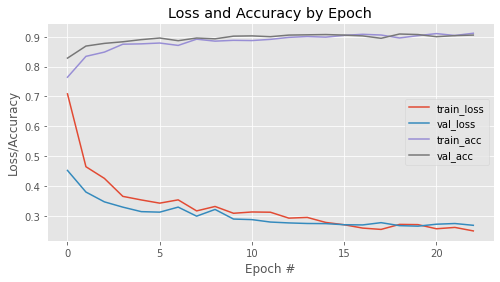

In [19]:
dataframe = pd.read_pickle('1.2.increased_bounding_box_annotated_image_dataframe.pkl')

data, labels = preprocess_images(dataframe)
check_lables_after_resizing(data, labels)

lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.30, stratify=labels, random_state = 22)
INIT_LR = .0005 # Set initial parameters
EPOCHS = 25
BS = 65

model, history = MobileNetV2_modelling(data, labels, X_train, X_test, y_train, y_test)
model_evaluation(history)

18/18 [==============================] - 18s 932ms/step



                       precision    recall  f1-score   support

mask_weared_incorrect       0.75      0.08      0.15        36
            with_mask       0.94      0.95      0.95       892
         without_mask       0.75      0.85      0.80       185

             accuracy                           0.91      1113
            macro avg       0.81      0.63      0.63      1113
         weighted avg       0.90      0.91      0.90      1113



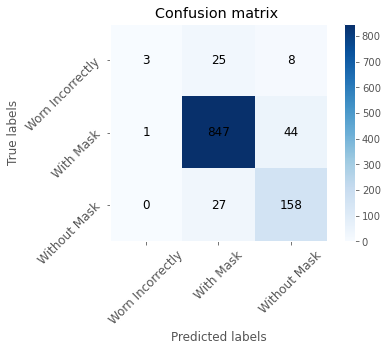


More Precisely: 


Reusing TensorBoard on port 6006 (pid 14352), started 4:42:37 ago. (Use '!kill 14352' to kill it.)

In [20]:
model_prediction(model, X_train, X_test, y_train, y_test, BS, lb)

In [22]:
model.save('2.2.resized_mobilev2net_detector.h5')